peak 0.9595432487341563


[ Info: Saved animation to /home/vlsh/Source/ECE 6340/E_wave.gif


Plots.AnimatedGif("/home/vlsh/Source/ECE 6340/E_wave.gif")
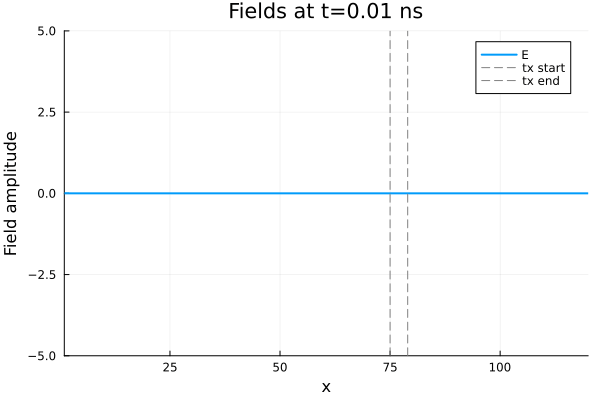

In [14]:
using Plots
using FFTW
gr()

# --------------------------------------------------------------------------- #
# Physical constants
# --------------------------------------------------------------------------- #
μ0 = 4π * 1e-7      # H/m
ϵ0 = 8.85e-12      # F/m
c  = 3e8           # m/s

# --------------------------------------------------------------------------- #
# Simulation parameters
# --------------------------------------------------------------------------- #
f = 2e9            # source frequency, Hz
λ = c / f          # wavelength in air, m
N = 120            # number of E nodes
Nt = 1000          # time steps
dx = λ / 20        # grid spacing, m
dt = dx / (2c)     # time step (Courant)

# Pulse parameters
t0 = 1 / f                 # pulse delay (center time)
τ  = 1.5 / f               # pulse width

# --------------------------------------------------------------------------- #
# Material: air → quarter-wave transformer → medium
# --------------------------------------------------------------------------- #
ϵr_medium = 4.0
ϵr_qTX    = sqrt(ϵr_medium)           # impedance match: η_tx = √(η₀ η_medium)
λ_qTX     = λ / sqrt(ϵr_qTX)          # wavelength in transformer
n_cells_qtx = max(1, round(Int, (λ_qTX/4) / dx))
layer_start  = 75
layer_end_qtx = layer_start + n_cells_qtx - 1

ϵ = fill(ϵ0, N)
for i in layer_start:N
    ϵ[i] = ϵr_medium * ϵ0
end
for i in layer_start:layer_end_qtx
    ϵ[i] = ϵr_qTX * ϵ0
end

# --------------------------------------------------------------------------- #
# Fields and Mur BC coefficients
# --------------------------------------------------------------------------- #
H = zeros(N)
E = zeros(N)
E_old = zeros(N)

v_medium   = c / sqrt(ϵr_medium)
coef_left  = (c*dt - dx) / (c*dt + dx)
coef_right = (v_medium*dt - dx) / (v_medium*dt + dx)
#coef_right = coef_left;

# 
E_probe = zeros(Nt)

peak_E = 0

# --------------------------------------------------------------------------- #
# Time stepping and animation
# --------------------------------------------------------------------------- #
anim = @animate for iter in 1:Nt
    E_old .= E

    # H update
    for x in 1:N-1
        H[x] += (dt / (μ0*dx)) * (E[x] - E[x+1])
    end

    # E update
    for x in 2:N
        E[x] += (dt / (ϵ[x]*dx)) * (H[x-1] - H[x])
    end

    # peak detection
    global peak_E = max(E[100], peak_E)

    # Soft source
    #E[Int(N/2)] += sin(iter * dt * 2π * f)

    # Pulse source
    #t = iter * dt
    #pulse = exp(-((t - t0)/τ)^2) * sin(2π * f * t)
    #E[Int(N/2)] += pulse

    # Pulse source (square burst)
    t = iter * dt
    
    # square carrier
    carrier = sign(sin(2π * f * t))
    
    # rectangular time window
    window = (t0 <= t <= t0 + τ) ? 1.0 : 0.0
    
    pulse = carrier * window
    
    E[Int(N/2)] += pulse

    # Mur ABCs
    E[1] = E_old[2]   + coef_left  * (E[2]   - E_old[1])
    E[N] = E_old[N-1] + coef_right * (E[N-1] - E_old[N])

    # Plot
    plot(1:N, E;
        xlim=(1, N), ylim=(-5, 5), lw=2, label="E",
        title="Fields at t=$(round(iter*dt*1e9, digits=2)) ns",
        xlabel="x", ylabel="Field amplitude")
    vline!([layer_start],      color=:gray, ls=:dash, label="tx start")
    vline!([layer_end_qtx+1],  color=:gray, ls=:dash, label="tx end")

    E_probe[iter] = E[20]
end

println("peak $(peak_E)");

gif(anim, "E_wave.gif", fps=20)




In [15]:
# using Pkg;
# Pkg.add("FFTW");

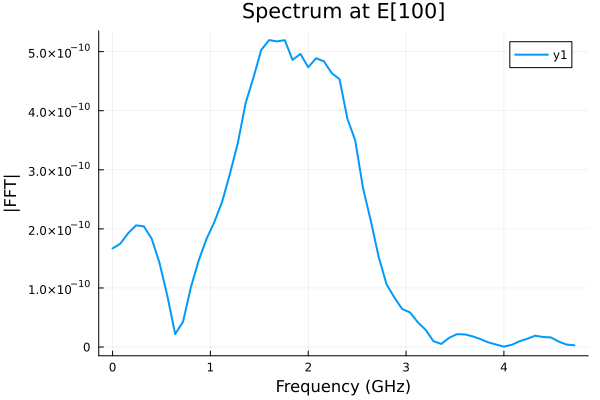

In [16]:
# -----------------------------
# FFT of probe signal
# -----------------------------
using FFTW

Y = fft(E_probe)
freq = (0:Nt-1) .* (1/(Nt*dt))   # frequency axis (Hz)

# Single-sided spectrum
half = 1:div(N,2)
Y_half = Y[half]*dt
freq_half = freq[half]

# Plot magnitude
plot(freq_half .* 1e-9, abs.(Y_half);
    xlabel="Frequency (GHz)",
    ylabel="|FFT|",
    title="Spectrum at E[100]",
    lw=2)

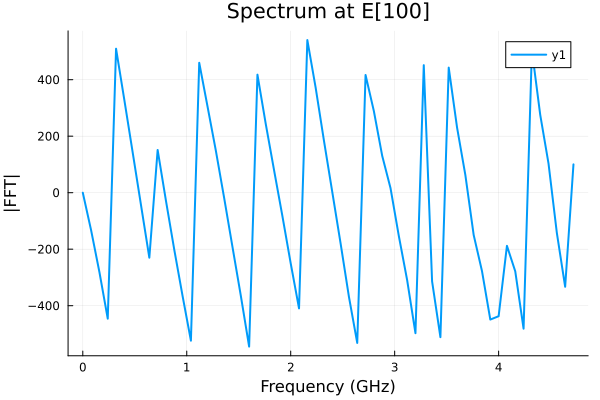

In [17]:
# Plot magnitude
plot(freq_half .* 1e-9, angle.(Y_half)*180;
    xlabel="Frequency (GHz)",
    ylabel="|FFT|",
    title="Spectrum at E[100]",
    lw=2)